# Transformers architecture

![model-architecture](https://alexandre.jouand.in/project/transformer-model/featured.png)

## Modeling

Let's start implementing Encoder first.

TODO: 
- [x] token embedding 🚀
- [ ] positional encoding ❎
- [ ] multi-head attention ❕
- [ ] layer normalization ❕
- [ ] feed forward ❕
- [ ] ENCODER ❕

❕ -> upcoming | ❎ -> in progress | 🚀 -> done | ⛔️ -> error

In [4]:
import torch
from torch import nn

## Inputs

In this experiment, we use the Multi30K dataset, which contains multilingual English-German image descriptions.

Example:
![](https://d3i71xaburhd42.cloudfront.net/bc9db6117d0026bc5b11eeba2303d2bddc96c306/3-Figure1-1.png)

#### Dataset

In [20]:
from torchtext.legacy.data import Field, BucketIterator
from torchtext.legacy.datasets.translation import Multi30k

Above we have 2 new classes which I personally don't know. So I did my research about them and found the following explanations:

Field class models common text processing datatypes that can be represented by tensors.  It holds a Vocab object that defines the set of possible values for elements of the field and their corresponding numerical representations. The Field object also holds other parameters relating to how a datatype should be numericalized, such as a tokenization method and the kind of Tensor that should be produced.

BuckerIterator Minimizes amount of padding needed while producing freshly shuffled batches for each new epoch. See pool for the bucketing procedure used.

### TL;DR
`Field`: Defines a datatype together with instructions for converting to Tensor.

`BuckerIterator`: Defines an iterator that batches examples of similar lengths together.

In [31]:
class DataLoader:
    # create 2 global variables for x -> source and y -> target
    source: Field = None
    target: Field = None
    
    
    def __init__(self, ext, tokenize_en, tokenize_de, init_token, eos_token):
        self.ext = ext
        self.tokenize_en = tokenize_en
        self.tokenize_de = tokenize_de
        self.init_token = init_token
        self.eos_token = eos_token
        print("Dataset initialization start")
    
    
    def make_dataset(self):
        # German --> English
        if self.ext == ('.de', '.en'):
            self.source = Field(tokenize=self.tokenize_de,
                                init_token=self.init_token,
                                eos_token=self.eos_token,
                                lower=True,
                                batch_first=True)
            self.target = Field(tokenize=self.tokenize_en,
                                init_token=self.init_token,
                                eos_token=self.eos_token,
                                lower=True,
                                batch_first=True)
        
        # English --> German
        elif self.ext == ('.en','.de'):
            self.source = Field(tokenize=self.tokenize_en,
                                init_token=self.init_token,
                                eos_token=self.eos_token,
                                lower=True,
                                batch_first=True)
            self.target = Field(tokenize=self.tokenize_de,
                                init_token=self.init_token,
                                eos_token=self.eos_token,
                                lower=True,
                                batch_first=True)
        
        train_data, valid_data, test_data = Multi30k.splits(exts=self.ext, fields=(self.source, self.target))
        return train_data, valid_data, test_data
    
    
    def build_vocab(self, train_data, min_freq):
        self.source.build_vocab(train_data, min_freq=min_freq)
        self.target.build_vocab(train_data, min_freq=min_freq)
    
    
    def make_iter(self, train, validate, test, batch_size, device):
        train_iterator, valid_iterator, test_iterator = BucketIterator.splits((train, validate, test),
                                                                              batch_size=batch_size,
                                                                              device=device)
        print("Dataset initialization done")
        return train_iterator, valid_iterator, test_iterator

#### Tokenizer

In [32]:
import spacy


class Tokenizer:
    
    
    def __init__(self):
        # load pretrained tokenizers
        self.spacy_de = spacy.load('de_core_news_sm')
        self.spacy_en = spacy.load('en_core_web_sm')
    
    
    def tokenize_de(self, text):
        """
        Tokenizes German text from a string into a list of strings
        
        :param text: input text in German        
        """
        print(type(text))
        return [tok.text for tok in self.spacy_de.tokenizer(text)]
    
    
    def tokenize_en(self, text):
        """
        Tokenizes English text from a string into a list of strings
        
        :param text: input text in English        
        """
        return [tok.text for tok in self.spacy_en.tokenizer(text)]

## Prepare data

In [33]:
tokenizer = Tokenizer()
loader = DataLoader(ext=('.en', '.de'),
                    tokenize_en=tokenizer.tokenize_en,
                    tokenize_de=tokenizer.tokenize_de,
                    init_token='<sos>',
                    eos_token='<eos>')

train, valid, test = loader.make_dataset()

Dataset initialization start


In [34]:
loader.build_vocab(train_data=train, min_freq=2)

In [35]:
batch_size = 128
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")

train_iterator, valid_iterator, test_iterator = loader.make_iter(train, valid, test,
                                                                 batch_size=batch_size,
                                                                 device=device)

Dataset initialization done


In [39]:
src_pad_idx = loader.source.vocab.stoi['<pad>']
trg_pad_idx = loader.target.vocab.stoi['<pad>']
trg_sos_idx = loader.target.vocab.stoi['<sos>']

In [43]:
enc_voc_size = len(loader.source.vocab)
dec_voc_size = len(loader.target.vocab)

In [48]:
print(f"Encoder vocabulary size: {enc_voc_size}")
print(f"Decoder vocabulary size: {dec_voc_size}")

Encoder vocabulary size: 5893
Decoder vocabulary size: 7853


Let's create TokenEmbedding class which uses torch.nn.

Here we will get a dense representation of words using a weighted matrix

In [51]:
class TokenEmbedding(nn.Embedding):
    
    
    def __init__(self, vocab_size, d_model):
        """
        class for token embedding that included positional information

        :param vocab_size: size of vocabulary
        :param d_model: dimensions of model
        """
        super(TokenEmbedding, self).__init__(vocab_size, d_model, padding_idx=1)

In [55]:
tok_emb = TokenEmbedding(enc_voc_size, d_model=512)
tok_emb

TokenEmbedding(5893, 512, padding_idx=1)

Now we can implement Positional Encoding

In [60]:
device

device(type='cuda', index=5)

In [107]:
encoding_ = torch.zeros(256, 512)
encoding_

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [108]:
encoding_[0].shape

torch.Size([512])

In [109]:
pos_ = torch.arange(0, 256)
pos_

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 1

In [110]:
pos_ = pos_.float().unsqueeze(dim=1)
pos_.shape

torch.Size([256, 1])

In [111]:
_2i_ = torch.arange(0, 512, step=2).float()

In [112]:
_2i_.shape

torch.Size([256])

In [113]:
encoding_[:, 0::2] = torch.sin(pos_ / (10000 ** (_2i_ / 512)))

In [114]:
encoding_

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 8.4147e-01,  0.0000e+00,  8.2186e-01,  ...,  0.0000e+00,
          1.0366e-04,  0.0000e+00],
        [ 9.0930e-01,  0.0000e+00,  9.3641e-01,  ...,  0.0000e+00,
          2.0733e-04,  0.0000e+00],
        ...,
        [ 9.9482e-01,  0.0000e+00, -8.3318e-01,  ...,  0.0000e+00,
          2.6224e-02,  0.0000e+00],
        [ 4.5200e-01,  0.0000e+00, -2.0163e-02,  ...,  0.0000e+00,
          2.6327e-02,  0.0000e+00],
        [-5.0639e-01,  0.0000e+00,  8.1020e-01,  ...,  0.0000e+00,
          2.6431e-02,  0.0000e+00]])

In [115]:
encoding_[:, 1::2] = torch.cos(pos_ / (10000 ** (_2i_ /512)))

In [116]:
encoding_[0]

tensor([0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 

In [117]:
encoding_[1]

tensor([8.4147e-01, 5.4030e-01, 8.2186e-01, 5.6969e-01, 8.0196e-01, 5.9738e-01,
        7.8189e-01, 6.2342e-01, 7.6172e-01, 6.4791e-01, 7.4154e-01, 6.7091e-01,
        7.2141e-01, 6.9250e-01, 7.0140e-01, 7.1276e-01, 6.8156e-01, 7.3176e-01,
        6.6193e-01, 7.4956e-01, 6.4256e-01, 7.6624e-01, 6.2347e-01, 7.8185e-01,
        6.0469e-01, 7.9646e-01, 5.8626e-01, 8.1012e-01, 5.6818e-01, 8.2290e-01,
        5.5048e-01, 8.3485e-01, 5.3317e-01, 8.4601e-01, 5.1625e-01, 8.5644e-01,
        4.9974e-01, 8.6618e-01, 4.8364e-01, 8.7527e-01, 4.6795e-01, 8.8376e-01,
        4.5267e-01, 8.9168e-01, 4.3781e-01, 8.9907e-01, 4.2335e-01, 9.0596e-01,
        4.0931e-01, 9.1240e-01, 3.9567e-01, 9.1839e-01, 3.8242e-01, 9.2399e-01,
        3.6957e-01, 9.2920e-01, 3.5711e-01, 9.3406e-01, 3.4503e-01, 9.3859e-01,
        3.3332e-01, 9.4281e-01, 3.2197e-01, 9.4675e-01, 3.1098e-01, 9.5042e-01,
        3.0034e-01, 9.5383e-01, 2.9004e-01, 9.5701e-01, 2.8008e-01, 9.5998e-01,
        2.7043e-01, 9.6274e-01, 2.6110e-

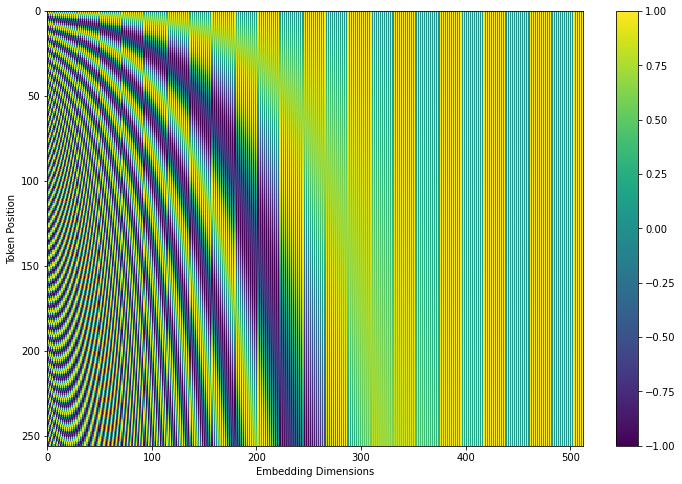

In [118]:
import numpy as np
import matplotlib.pyplot as plt

pos_encoding = encoding_[np.newaxis, ...]

plt.figure(figsize=(12,8))
plt.pcolormesh(pos_encoding[0], cmap='viridis')
plt.xlabel('Embedding Dimensions')
plt.xlim((0, 512))
plt.ylim((256,0))
plt.ylabel('Token Position')
plt.colorbar()
plt.show()

In [121]:
class PositionalEncoding(nn.Module):
    
    
    def __init__(self, d_model, max_len, device):
        """
        initialize sinusoid encoding class
        
        :param d_model: dimension of model
        :param max_len: maximum length of the sequence 
        :param device: hardware device
        """
        super(PositionalEncoding, self).__init__()
        
        # same size with input matrix (to add (+) input matrix)
        self.encoding = torch.zeros(max_len, d_model, device=device)
        self.encoding.requires_grad = False  # we don't need to compute gradients
        
        pos = torch.arange(0, max_len, device=device)
        pos = pos.float().unsqueeze(dim=1)  # 1D --> 2D unsqueeze to represent word's position
        
        _2i = torch.arange(0, d_model, step=2, device=device).float()
        # 'i' means index of d_model (e.g. embedding size = 50, 'i' = [0,50])
        # "step=2" means 'i' multiplied with two (same with 2 * i)

        self.encoding[:, 0::2] = torch.sin(pos / (10000 ** (_2i / d_model)))
        self.encoding[:, 1::2] = torch.cos(pos / (10000 ** (_2i / d_model)))
        # compute positional encoding to consider positional information of words

        
    def forward(self, x):
        # self.encoding
        # [max_len = 512, d_model = 512]

        batch_size, seq_len = x.size()
        # [batch_size = 128, seq_len = 30]

        return self.encoding[:seq_len, :]
        # [seq_len = 30, d_model = 512]
        # it will add with tok_emb : [128, 30, 512]

In [124]:
pos_emb = PositionalEncoding(512, 256, device)

In [125]:
pos_emb

PositionalEncoding()

In [ ]:
class Encoder(nn.Module):
    
    
    def __init__(self, enc_voc_size, max_len, d_model, ffn_hidden, n_head, n_layers, drop_prob, device,):
        super().__init__()
        self.emb = TransformerEmbedding()
    
    
    def forward():
        pass